In [1]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.constants import c, hbar, m_n, M_sun, G
from astropy import units as u

from scipy.integrate import odeint, solve_ivp

# Non Relativistic (k_F << m)

In [2]:
#----------------------------
#Define the parameters
#----------------------------

AZ = 1
K_nonrel = (hbar ** 2 / 15 / np.pi**2 / m_n * ((3 * np.pi**2)/ (m_n * c**2 * AZ)) **(5/3)).to('cm2 / erg**(2/3)')
gamma = 5/3
R0 = 1.473 * u.km

alpha = 1 * u.km

e_0 = (( (R0 / alpha) ** gamma / K_nonrel ) **( 1/(gamma-1))).to('erg/cm3')

beta = (4 * np.pi * e_0 / (M_sun * c**2 * (K_nonrel * e_0 **(gamma-1))**(1/gamma))).to('1/km3')
    
K = K_nonrel * (e_0 **(gamma-1))

lambda0 = (4 * np.pi * e_0 / c**2 / M_sun).to('1/km3')

print('K:', K)
print('beta:', beta)
print('K_nonrel:', K_nonrel.to('cm2 / erg**(2/3)'))
print('lambda:', lambda0)


K: 1.906943876256988
beta: 0.7713646930453346 1 / km3
K_nonrel: 6.427932009448279e-26 cm2 / erg(2/3)
lambda: 1.1362201928557767 1 / km3


In [3]:
#-------------------------
#Estimate central pressure
#-------------------------

M = 1 * M_sun
R = 10 * u.km
P_c_units = (K_nonrel * ( (3 * M * c**2) / (4 * np.pi * R**3) )**gamma).to('erg/cm3')

P_c = P_c_units / e_0
print(f'Central pressure for M={M:.2e}, R={R}: P_c={P_c:.2}')
print('Energy density unit:', e_0)


Central pressure for M=1.99e+30 kg, R=10.0 km: P_c=9.6e-05
Energy density unit: 1.6158459552580226e+38 erg / cm3


Basically Central pressure P_c = 1e-4

Pc=0.0001 e0 -> R=15.284 km, M=0.6156 M_sun


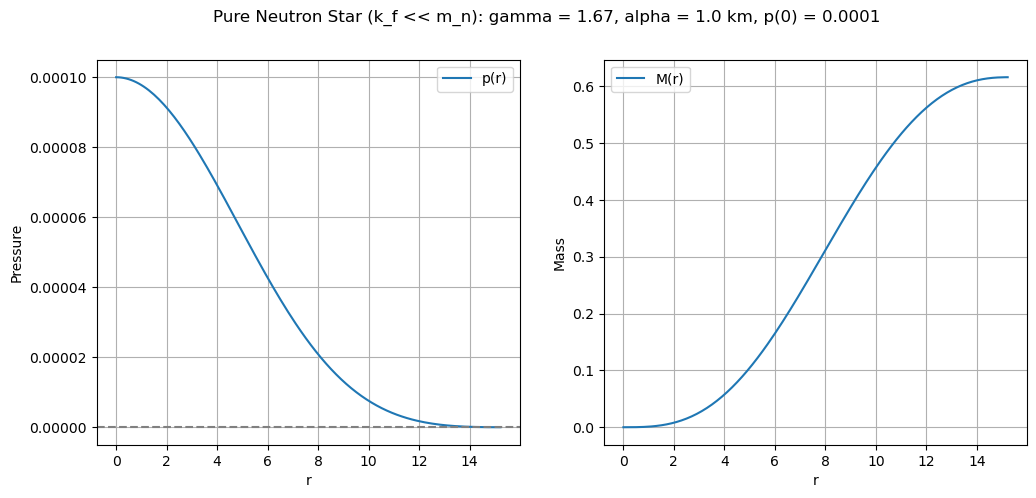

In [4]:
#-----------------------
#Define the ODE system
#-----------------------


def TOV_nonrel(r, x):
    p, M = x
    if p <= 0:
        return [0, 0]

    term1 = alpha.value * M * p**(1 / gamma) / r**2
    term2 = 1 - (K * p ** (gamma - 1) ** (1 / gamma))
    term3 = 1 + lambda0.value * p * r**3 / M
    term4 = 1 - 2 * R0.value * M / r

    # Add a small epsilon to term4 to avoid division by zero
    epsilon = 1e-10
    dpdr = -term1 * term2 * term3 / (term4 + epsilon)
    dMdr = beta.value * r**2 * p**(1 / gamma)
    return [dpdr, dMdr]


#-----------------------
#Solve
#-----------------------
P_c = 1e-4  #Initial central pressure in units of e_0
r0 = 0.001  #Avoid singularity at r=0
m0 = (4.0/3.0 * np.pi * r0**3 * (u.km)**3 * (3.0* P_c * u.erg / (u.cm) **3 /c**2)) / M_sun
rmax = 100

x_init = [P_c, m0]
r_span = (r0, rmax)  #Integration range
r_eval = np.linspace(r0, rmax, rmax * 10) #Points where solution is evaluated

def stop_at_zero_pressure(r, y):
    return y[0]
stop_at_zero_pressure.terminal = True
stop_at_zero_pressure.direction = -1

sol = solve_ivp(TOV_nonrel,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

if sol.t_events[0].size > 0:
        Rsurf = sol.t_events[0][0]
else:
        Rsurf = sol.t[-1]
Mfinal = sol.y[1, -1]

print(f"Pc={P_c} e0 -> R={Rsurf:.3f} km, M={Mfinal:.4f} M_sun")





#-----------------------
#Plot results
#-----------------------

r = sol.t ; p = sol.y[0] ; M = sol.y[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(r, p, label="p(r)")
ax1.axhline(0, color="gray", linestyle="--")
ax1.set_xlabel('r')
ax1.set_ylabel('Pressure')
ax1.legend()
ax1.grid()


ax2.plot(r, M, label="M(r)")
ax2.set_xlabel('r')
ax2.set_ylabel('Mass')
ax2.grid()
ax2.legend()

fig.suptitle(f'Pure Neutron Star (k_f << m_n): gamma = {gamma:.3}, alpha = {alpha}, p(0) = {P_c}')

plt.show()




In [5]:
#-----------------------
# Try for different central pressures
#-----------------------
import pandas as pd

p_c_values = [1e-7, 1e-6, 1e-5, 1e-4]
data =[]
for pc in p_c_values:
    #-----------------------
    #Solve
    #-----------------------

    r0 = 0.001  #Avoid singularity at r=0
    m0 = (4.0/3.0 * np.pi * r0**3 * (u.km)**3 * (3.0* pc * u.erg / (u.cm) **3 /c**2)) / M_sun
    rmax = 100

    x_init = [pc, m0]
    r_span = (r0, rmax)  #Integration range
    r_eval = np.linspace(r0, rmax, rmax * 10) #Points where solution is evaluated

    sol = solve_ivp(TOV_nonrel,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

    if sol.t_events[0].size > 0:
            Rsurf = sol.t_events[0][0]
    else:
            Rsurf = sol.t[-1]
    Mfinal = sol.y[1, -1]

    result = [pc, Rsurf, Mfinal]
    data.append(result)

non_rel_data = pd.DataFrame(data, columns=['P_c', 'R_km', 'M_solar'])
non_rel_data

,P_c,R_km,M_solar
0,1.000000e-07,32.682865,0.095572
1,1.000000e-06,25.759991,0.186432
2,1.000000e-05,20.075475,0.351922
3,1.000000e-04,15.283676,0.615635


# Relativistic (k_F >> m)

In [6]:
#----------------------------
#Define the parameters
#----------------------------

K_rel = 1.00 / 3.00
gamma = 1.00
R0 = (G * M_sun / c**2).to(u.km)  

alpha = 3 * R0

beta_ntrn =( 12 * np.pi / c ** 2 / M_sun * e_0).to('1/km3')
   
K = K_rel 

lambda0 = beta_ntrn  / 3

print('K:', K)
print('beta:', beta_ntrn)
print('lambda:', lambda0)


K: 0.3333333333333333
beta: 3.4086605785673303 1 / km3
lambda: 1.1362201928557767 1 / km3


In [7]:
#-------------------------
#Estimate central pressure
#-------------------------

M = 1 * M_sun
R = 10 * u.km
P_c_units = (K_rel * ( (3 * M * c**2) / (4 * np.pi * R**3) )**gamma).to('erg/cm3')

P_c = P_c_units / e_0
print(f'Central pressure for M={M:.2e}, R={R}: P_c={P_c:.2}')
print('Energy density unit:', e_0)


Central pressure for M=1.99e+30 kg, R=10.0 km: P_c=0.00088
Energy density unit: 1.6158459552580226e+38 erg / cm3


Central pressure P_c = 1e-3

Pc=0.0001 e0 -> R=200.000 km, M=19.3734 M_sun


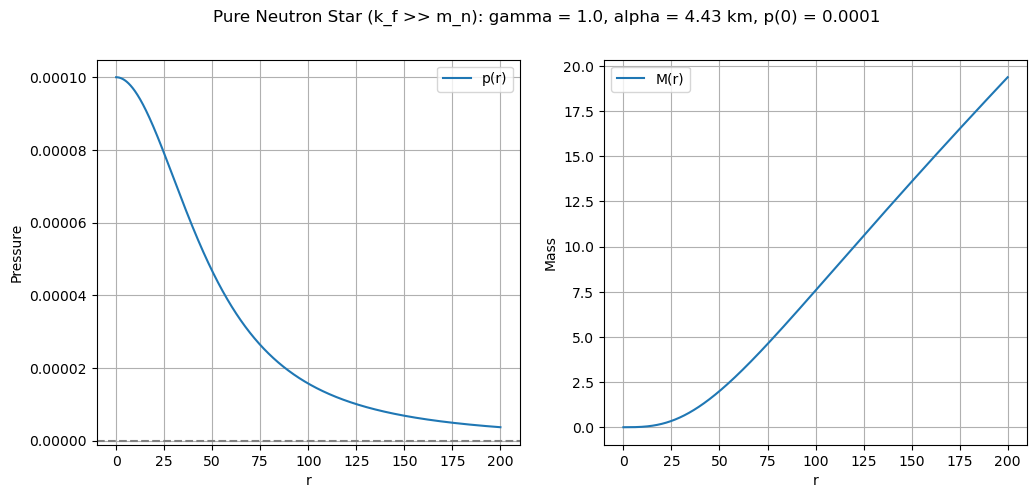

In [8]:
#-----------------------
#Define the ODE system
#-----------------------


def TOV_rel(r, x):
    p, M = x
    if p <= 0:
        return [0.0, 0.0]

    term1 = alpha.value * M * p / r**2
    term2 = 4 / 3
    term3 = 1 + lambda0.value * p * r**3 / M
    denom = 1 - 2 * R0.value * M / r

    if denom <= 0:
        return [0.0, 0.0]
    dpdr = -term1 * term2 * term3 / denom
    dMdr = beta.value * r**2 * p 
    return [dpdr, dMdr]

def stop_at_zero_pressure(r, y):
    return y[0]
stop_at_zero_pressure.terminal = True
stop_at_zero_pressure.direction = -1


#-----------------------
#Solve
#-----------------------
Pc = 1e-4
r0 = 1e-3
m0 = (4.0/3.0 * np.pi * r0**3 * (u.km)**3 * (3.0* Pc * u.erg / (u.cm) **3 /c**2)) / M_sun
rmax = 200

x_init = [Pc, m0.value]
r_span = (r0, rmax)  #Integration range
r_eval = np.linspace(r0, rmax, 5000) #Points where solution is evaluated



sol = solve_ivp(TOV_rel,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

if sol.t_events[0].size > 0:
        Rsurf = sol.t_events[0][0]
else:
        Rsurf = sol.t[-1]
Mfinal = sol.y[1, -1]


print(f"Pc={Pc} e0 -> R={Rsurf:.3f} km, M={Mfinal:.4f} M_sun")

#-----------------------
#Plot results
#-----------------------

r = sol.t; p = sol.y[0]; M = sol.y[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(r, p, label="p(r)")
ax1.axhline(0, color="gray", linestyle="--")
ax1.set_xlabel('r')
ax1.set_ylabel('Pressure')
ax1.legend()
ax1.grid()


ax2.plot(r, M, label="M(r)")
ax2.set_xlabel('r')
ax2.set_ylabel('Mass')
ax2.grid()
ax2.legend()

fig.suptitle(f'Pure Neutron Star (k_f >> m_n): gamma = {gamma:.3}, alpha = {alpha:.4}, p(0) = {Pc}')

plt.show()



In [9]:
#-----------------------
# Try for different central pressures
#-----------------------

p_c_values = [1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0]
data =[]
for pc in p_c_values:
    #-----------------------
    #Solve
    #-----------------------

    r0 = 0.001  #Avoid singularity at r=0
    m0 = (4.0/3.0 * np.pi * r0**3 * (u.km)**3 * (3.0* pc * u.erg / (u.cm) **3 /c**2)) / M_sun
    rmax = 200

    x_init = [pc, m0]
    r_span = (r0, rmax)  #Integration range
    r_eval = np.linspace(r0, rmax, rmax * 10) #Points where solution is evaluated

    sol = solve_ivp(TOV_rel,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

    if sol.t_events[0].size > 0:
            Rsurf = sol.t_events[0][0]
    else:
            Rsurf = sol.t[-1]
    Mfinal = sol.y[1, -1]

    result = [pc, Rsurf, Mfinal]
    data.append(result)

rel_data = pd.DataFrame(data, columns=['P_c', 'R_km', 'M_solar'])
rel_data



,P_c,R_km,M_solar
0,1.000000e-07,200.0,0.203686
1,1.000000e-06,200.0,1.872655
2,1.000000e-05,200.0,10.453213
3,1.000000e-04,200.0,19.373388
4,1.000000e-03,200.0,20.116395
5,1.000000e-02,200.0,19.536896
6,1.000000e-01,200.0,19.451979
7,1.000000e+00,200.0,19.493525


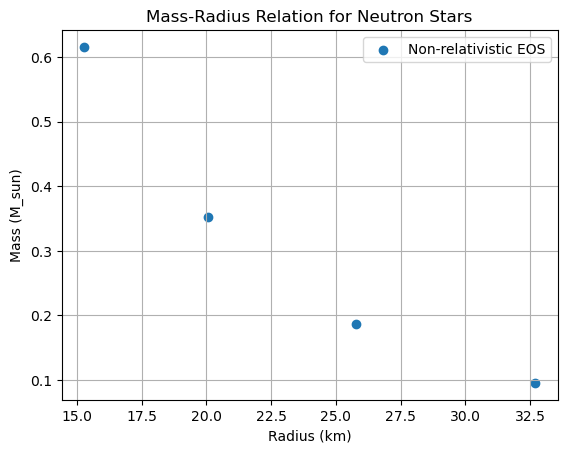

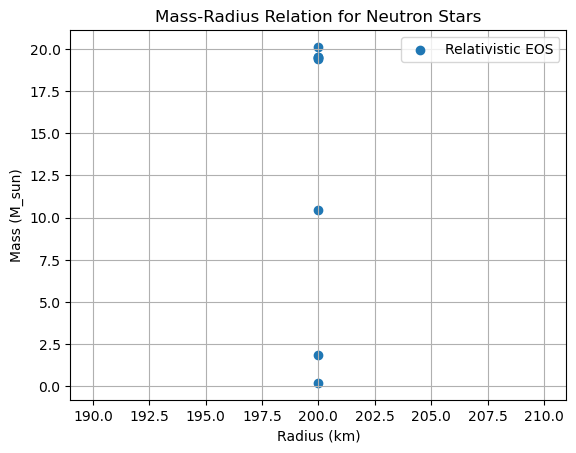

In [10]:
plt.scatter(non_rel_data['R_km'], non_rel_data['M_solar'], label='Non-relativistic EOS', marker='o')

plt.xlabel('Radius (km)')
plt.ylabel('Mass (M_sun)')
plt.title('Mass-Radius Relation for Neutron Stars')
plt.legend()
plt.grid()

plt.show()

plt.scatter(rel_data['R_km'], rel_data['M_solar'], label='Relativistic EOS', marker='o')

plt.xlabel('Radius (km)')
plt.ylabel('Mass (M_sun)')
plt.title('Mass-Radius Relation for Neutron Stars')
plt.legend()
plt.grid()

plt.show()


# General equation

e = A_NR * p **(3/5) + A_R * p

In [11]:
#----------------------------
#Define the parameters
#----------------------------
A_NR = 2.4216 
A_R = 2.8663 

alpha = R0

e_0 = (5.346e36 * u.erg / u.cm**3).to('erg/km3')

R0 = (G * M_sun / c**2).to(u.km)  

beta = (4 * np.pi * e_0 / (M_sun * c**2)).to('1/km3')

print('Energy density unit:', e_0)  
print('R0:', R0)
print('A_NR:', A_NR)
print('A_R:', A_R)
print('beta:', beta)



Energy density unit: 5.3459999999999995e+51 erg / km3
R0: 1.476625038050125 km
A_NR: 2.4216
A_R: 2.8663
beta: 0.037591659843818674 1 / km3


Pc=0.01 e0 -> R=13.460 km, M=0.7178 M_sun
Pc=0.01 e0 -> R=15.039 km, M=1.0390 M_sun


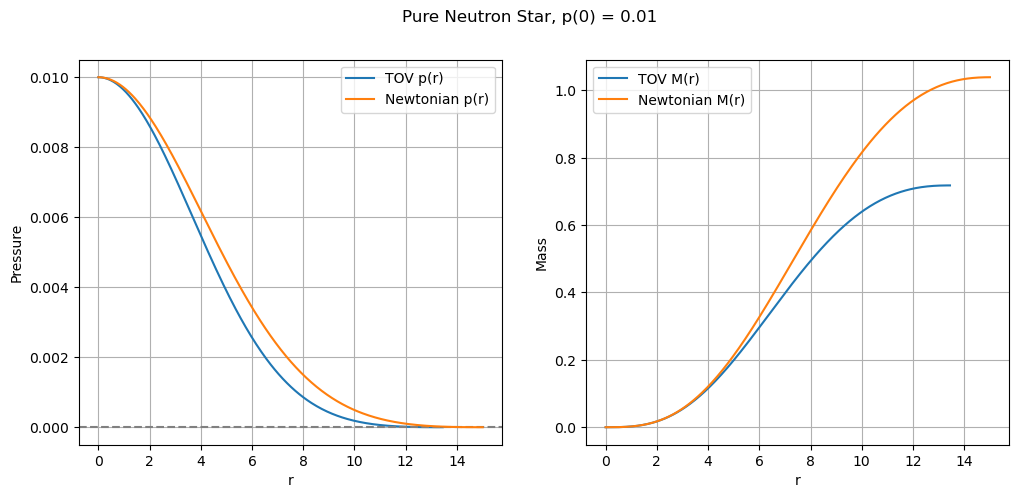

In [12]:
#-----------------------
#Define the ODE system
#-----------------------


def TOV_gen(r, x):
    p, M = x
    if p <= 0:
        return [0.0, 0.0]

    eps = A_NR * p**(3/5) + A_R * p

    term1 = alpha.value * eps * M / r **2 
    term2 = 1 +  p / eps
    term3 = 1 + beta.value * p * r**3 / M
    denom = 1 - 2 * R0.value * M / r

    if denom <= 0:
        return [0.0, 0.0]
    dpdr = -term1 * term2 * term3 / denom
    dMdr = beta.value * r**2 * eps 
    return [dpdr, dMdr]

def stop_at_zero_pressure(r, y):
    return y[0]
stop_at_zero_pressure.terminal = True
stop_at_zero_pressure.direction = -1


#-----------------------
#Solve
#-----------------------
Pc = 0.01
r0 = 1e-3
m0 = (4.0/3.0 * np.pi * r0**3 * (u.km)**3 * (3.0* Pc * u.erg / (u.cm) **3 /c**2)) / M_sun
rmax = 200

x_init = [Pc, m0.value]
r_span = (r0, rmax)  #Integration range
r_eval = np.linspace(r0, rmax, 5000) #Points where solution is evaluated



sol = solve_ivp(TOV_gen,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

if sol.t_events[0].size > 0:
        Rsurf = sol.t_events[0][0]
else:
        Rsurf = sol.t[-1]
Mfinal = sol.y[1, -1]


print(f"Pc={Pc} e0 -> R={Rsurf:.3f} km, M={Mfinal:.4f} M_sun")

#-----------------------
#Plot results
#-----------------------

r = sol.t; p = sol.y[0]; M = sol.y[1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(r, p, label="TOV p(r)")
ax1.axhline(0, color="gray", linestyle="--")
ax1.set_xlabel('r')
ax1.set_ylabel('Pressure')

ax1.grid()


ax2.plot(r, M, label="TOV M(r)")
ax2.set_xlabel('r')
ax2.set_ylabel('Mass')
ax2.grid()


fig.suptitle(f'Pure Neutron Star, p(0) = {Pc}')

#-----------------------
#Plot results for Newtonian solutions
#-----------------------

def newton_gen(r, x):
    p, M = x
    if p <= 0:
        return [0.0, 0.0]

    eps = A_NR * p**(3/5) + A_R * p

    dpdr = - alpha.value * eps * M / r **2 

    dMdr = beta.value * r**2 * eps 
    return [dpdr, dMdr]


sol = solve_ivp(newton_gen,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

if sol.t_events[0].size > 0:
        Rsurf = sol.t_events[0][0]
else:
        Rsurf = sol.t[-1]
Mfinal = sol.y[1, -1]

r = sol.t; p = sol.y[0]; M = sol.y[1]
print(f"Pc={Pc} e0 -> R={Rsurf:.3f} km, M={Mfinal:.4f} M_sun")

ax1.plot(r, p, label="Newtonian p(r)")
ax2.plot(r, M, label="Newtonian M(r)")
ax1.legend()
ax2.legend()
plt.show()


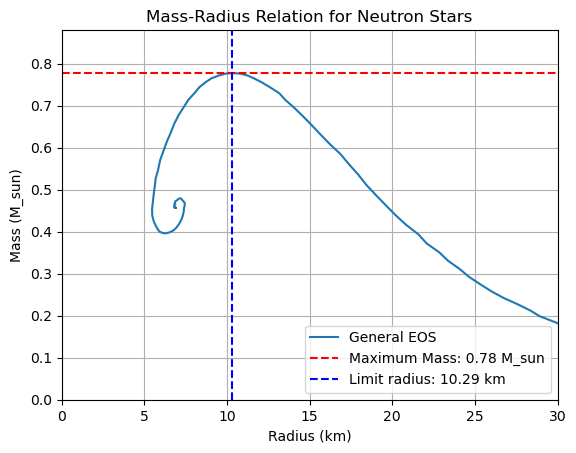

In [20]:
#-----------------------
# Try for different central pressures
#-----------------------


p_c_values = np.logspace(-10, 5, 18 *8 )
data =[]
for pc in p_c_values:
    #-----------------------
    #Solve
    #-----------------------

    r0 = 0.001  #Avoid singularity at r=0
    m0 = (4.0/3.0 * np.pi * r0**3 * (u.km)**3 * (3.0* pc * u.erg / (u.cm) **3 /c**2)) / M_sun
    rmax = 200

    x_init = [pc, m0]
    r_span = (r0, rmax)  #Integration range
    r_eval = np.linspace(r0, rmax, rmax * 100) #Points where solution is evaluated

    sol = solve_ivp(TOV_gen,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

    if sol.t_events[0].size > 0:
            Rsurf = sol.t_events[0][0]
    else:
            Rsurf = sol.t[-1]
    Mfinal = sol.y[1, -1]

    result = [pc, Rsurf, Mfinal]
    data.append(result)

gen_data = pd.DataFrame(data, columns=['P_c', 'R_km', 'M_solar'])

# Trobar el valor màxim de la massa i el radi corresponent
max_mass = gen_data['M_solar'].max()
max_radius = gen_data.loc[gen_data['M_solar'].idxmax(), 'R_km']

# Gràfic
plt.plot(gen_data['R_km'], gen_data['M_solar'], label='General EOS')

# Afegir línia i text per a la massa màxima
plt.axhline(y=max_mass, color='red', linestyle='--', label=f'Maximum Mass: {max_mass:.2f} M_sun')
plt.axvline(x=max_radius, color='blue', linestyle='--', label=f'Limit radius: {max_radius:.2f} km')

# Etiquetes i configuració del gràfic
plt.xlabel('Radius (km)')
plt.ylabel('Mass (M_sun)')
plt.title('Mass-Radius Relation for Neutron Stars')
plt.legend()
plt.grid()
plt.xlim(0, 30)
plt.ylim(0, 0.8 * 1.1)

# Mostrar el gràfic
plt.show()



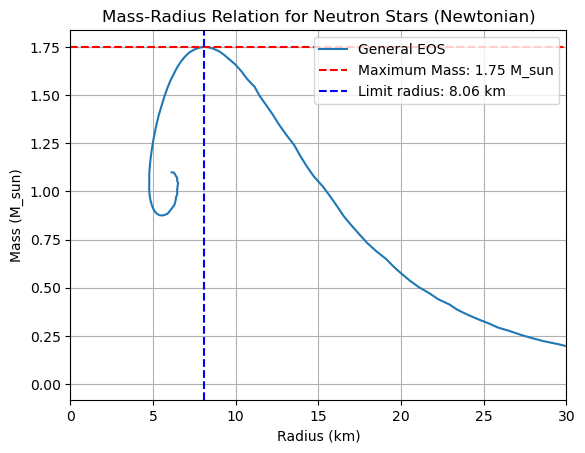

In [24]:
#-----------------------
# Try for different central pressures
#-----------------------


p_c_values = np.logspace(-10, 5, 18 *8 )
data =[]
for pc in p_c_values:
    #-----------------------
    #Solve
    #-----------------------

    r0 = 0.001  #Avoid singularity at r=0
    m0 = (4.0/3.0 * np.pi * r0**3 * (u.km)**3 * (3.0* pc * u.erg / (u.cm) **3 /c**2)) / M_sun
    rmax = 200

    x_init = [pc, m0]
    r_span = (r0, rmax)  #Integration range
    r_eval = np.linspace(r0, rmax, rmax * 100) #Points where solution is evaluated

    sol = solve_ivp(newton_gen,  r_span, x_init, t_eval=r_eval, events=stop_at_zero_pressure, max_step=100.0, rtol=1e-6, atol=1e-8)

    if sol.t_events[0].size > 0:
            Rsurf = sol.t_events[0][0]
    else:
            Rsurf = sol.t[-1]
    Mfinal = sol.y[1, -1]

    result = [pc, Rsurf, Mfinal]
    data.append(result)

gen_data = pd.DataFrame(data, columns=['P_c', 'R_km', 'M_solar'])

# Trobar el valor màxim de la massa i el radi corresponent
max_mass = gen_data['M_solar'].max()
max_radius = gen_data.loc[gen_data['M_solar'].idxmax(), 'R_km']

# Gràfic
plt.plot(gen_data['R_km'], gen_data['M_solar'], label='General EOS')

# Afegir línia i text per a la massa màxima
plt.axhline(y=max_mass, color='red', linestyle='--', label=f'Maximum Mass: {max_mass:.2f} M_sun')
plt.axvline(x=max_radius, color='blue', linestyle='--', label=f'Limit radius: {max_radius:.2f} km')

# Etiquetes i configuració del gràfic
plt.xlabel('Radius (km)')
plt.ylabel('Mass (M_sun)')
plt.title('Mass-Radius Relation for Neutron Stars (Newtonian)')
plt.legend()
plt.grid()
plt.xlim(0, 30)
#plt.ylim(0, 0.8 * 1.1)

# Mostrar el gràfic
plt.show()

